## Load custom data and build transform pipeline: Segment Anything as example

[Segment Anything](https://segment-anything.com/) (SA-1B) is an image segmentation dataset containing 1B masks and 11M images. The source dataset has the following file layout:

```
sa_000000/sa_1.json
         /sa_1.jpg
         /sa_2.json
         /sa_2.jpg
         ...
sa_000001/...
```

where each JSON file contains an image information and its annotations. This example builds a mini pipeline that loads, processes, manages, and feeds data to ML frameworks. We add more complexities to show the features of Space:

- JSON data are loaded to a `raw dataset` stored in Parquet. Images are not loaded. This dataset is good for running data mutations and OLAP queries on annotations.
- The raw dataset is transformed to a `preprocessed images materialized view` stored in [ArrayRecord](https://github.com/google/array_record). When the raw dataset is modified, refreshing the materialized view (MV) synchronizes changes incrementally. Because annotations are excluded here, the images can be shared by different training tasks, by joining with different annotation tables.
- Similarly, the raw dataset is also transformed to an `annotations materialized view`.
- Both MVs are keyed by `image_id`, they are joined (low cost JOIN of row addresses instead of real data) to re-construct the `<image, annotation>` pairs. A PyTorch style random access data source is built from the JOIN result, for feeding data to ML frameworks.

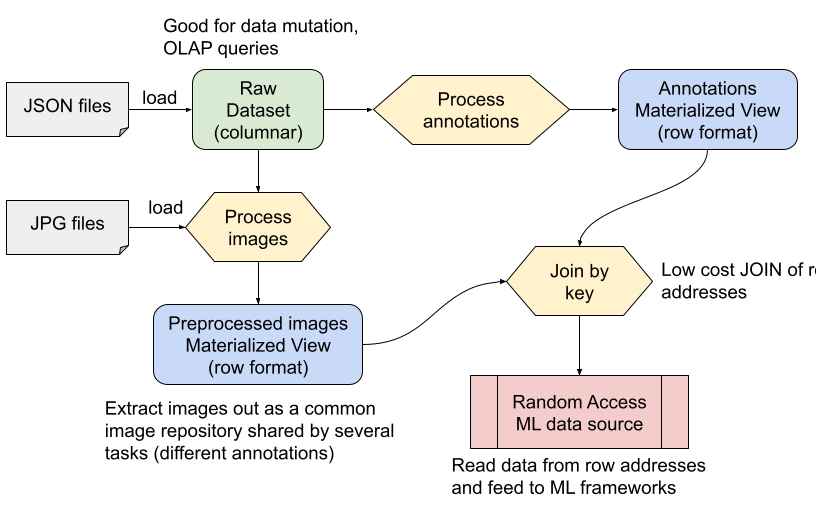

In [2]:
from IPython.display import Image
Image(filename="pics/space_segment_anything_example.png", width=600)

### Load Raw Data into Space Datasets

The first steps load JOSN files into a Space dataset. The equivalent PyArrow schema for the Space dataset/JSON file is:

In [ ]:
import pyarrow as pa

segmentation_schema = pa.struct([
  ("size", pa.list_(pa.int64())),
  ("counts", pa.string())
])

annotation_schema = pa.struct([
  ("area", pa.int64()),
  ("bbox", pa.list_(pa.float64())),
  ("crop_box", pa.list_(pa.float64())),
  ("id", pa.int64()),
  ("point_coords", pa.list_(pa.list_(pa.float64()))),
  ("predicted_iou", pa.float64()),
  ("segmentation", segmentation_schema),
  ("stability_score", pa.float64())
])

image_schema = pa.struct([
  ("image_id", pa.int64()),
  ("file_name", pa.string()),
  ("width", pa.int64()),
  ("height", pa.int64())
])

# This is the top level dataset schema.
ds_schema = pa.schema([
  ("image_id", pa.int64()),  # Add an image_id as the primary key.
  ("shard", pa.string()),  # Add shard ("sa_000000") for inferring full image path later.
  ("image", image_schema),
  ("annotations", pa.list_(annotation_schema))
])

The following method reads JSON files into Arrow tables, one row per file. Each row represents an image with annotations. It simply uses `pyarrow.json.read_json` to load JSON to Arrow.

In [ ]:
from typing import Iterator, List

import glob
import os
from pyarrow import json

sa_dir = "/segment_anything"  # Change to your data folder.
# Knobs for making things faster.
images_per_shard = 100
total_shards = 10


def make_iter(shards: List[str]) -> Iterator[pa.Table]:

  def json_files_to_arrow(shard: str) -> pa.Table:
    batch: List[pa.Table] = []

    pattern = os.path.join(sa_dir, shard, "*.json")
    print(f"processing pattern: {pattern}")
    for f in glob.glob(pattern):
      batch.append(json.read_json(f,
        parse_options=json.ParseOptions(explicit_schema=ds_schema)))
      if len(batch) >= images_per_shard:
        break

    table = pa.concat_tables(batch)
    image_id_column = table.column("image").combine_chunks().field("image_id")
    shard_column = pa.StringArray.from_pandas([shard] * table.num_rows)

    # Add image_id and shard columns to the original data.
    table = table.drop("shard").append_column(
      pa.field("shard", pa.string()), shard_column)
    table = table.drop("image_id").append_column(
      pa.field("image_id", pa.int64()), image_id_column)
    return table

  for shard in shards:
    yield json_files_to_arrow(shard)

Create an empty Space dataset:

In [ ]:
from space import Dataset

raw_ds_location = "/space/datasets/raw_data"

# `record_fields` specifies which fields to store in ArrayRecord.
# The raw dataset is pure Parquet, so leave it empty.
raw_ds = Dataset.create(raw_ds_location, ds_schema,
  primary_keys=["image_id"], record_fields=[])

After creation, the dataset can be loaded from location later:

In [ ]:
raw_ds = Dataset.load(raw_ds_location)

Now start loading JSON data into Space distributedly using Ray:

In [ ]:
# append_from accepts a list of no-args methods that returns a generator.
# A method is used because generator cannot be pickled for distributed execuion.
raw_ds.ray().append_from(
  [lambda idx=i: make_iter([f"sa_{idx:06}"]) for i in range(total_shards)])

### Pre-processed Image MVs

After loading image information and annotations into Space, next step we read and pre-process images, then persist the result in a Space Materialized View (MV).

First define a function to load and process images for a batch of inputs. The Ray runner uses [Ray map_batches](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html) internally, so the input format is `Dict[str, np.ndarray]`, where key is field names in the raw dataset.

In [ ]:
from typing import Any, Dict
import cv2

def read_and_preprocess_image(data: Dict[str, Any]) -> Dict[str, Any]:
  ims = []
  for image_id, shard, image in zip(data["image_id"], data["shard"], data["image"]):
    full_path = os.path.join(sa_dir, shard, image["file_name"])
    im = cv2.imread(full_path)
    im = cv2.resize(im, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
    ims.append(im.tobytes())

  # Drop `image` column that won't write into the output view, add a new
  # `image_bytes` column.
  del data["image"]
  data["image_bytes"] = ims
  return data

Create a view `image_view` by transforming the raw dataset using the function above. By providing an `input_fields`, we only read these fields from the dataset to save IO (annotations are not read). The output schema must be compatible with the data returned by `read_and_preprocess_image`.

In [ ]:
# Create a view by transforming the source dataset.
image_view = raw_ds.map_batches(
  fn=read_and_preprocess_image,
  input_fields=["image_id", "shard", "image"], # Exclude the `annotations` field.
  output_schema=pa.schema([
    ("image_id", pa.int64()),
    ("shard", pa.string()),
    ("image_bytes", pa.binary())  # Add a new field for image bytes.
  ]),
  output_record_fields=["image_bytes"]  # Store this field in ArrayRecord.
)

Queries on `image_view` reads all data from `raw_ds` and running the transform again. To avoid that, we can **materialize** the view:

In [ ]:
# Create an empty MV.
image_mv_location = "/space/mvs/images"
image_mv = image_view.materialize(image_mv_location)

# Synchronize the MV to the source dataset. It populates the MV storage.
image_mv.ray().refresh()

# Verifly the images in MV.
image_mv.ray().read_all().num_rows

Same as datasets, MVs can be loaded from file location anytime:

In [ ]:
from space import MaterializedView

image_mv = MaterializedView.load(image_mv_location)

Make some modifications in the source dataset, and synchronize changes to MV.

In [ ]:
# Show all image IDs, and pick a few to delete.
raw_ds.local().read_all().select(["image_id"])

# Delete two images.
raw_ds.local().delete((pc.field("image_id") == 4811) | (pc.field("image_id") == 6973))

image_mv.ray().refresh()
# The images are deleted in MV.
image_mv.local().read_all().select(["image_id"]).num_rows

### Annotations MVs

This step creates a MV for annotations. Because there can be hundreds of objects with segmentation data in annotations, its size is much larger than other datasets. This example stores serialized annotations (`annotations_bytes`) in ArrayRecord.

In [ ]:
import pickle

def serialize_annotations(data: Dict[str, Any]) -> Dict[str, Any]:
  # pickle is just an example of serialization.
  data["annotations_bytes"] = [pickle.dumps(d) for d in data["annotations"]]
  return data


# Create a view by transforming the source dataset.
annotations_view = ds.map_batches(
  fn=serialize_annotations,
  input_fields=["image_id", "annotations"],
  output_schema=pa.schema([
    ("image_id", pa.int64()),
    ("annotations_bytes", pa.binary())
  ]),
  output_record_fields=["annotations_bytes"]
)

# Create an empty MV.
annotations_mv_location = "/space/mvs/annotations"
annotations_mv = annotations_view.materialize(annotations_mv_location)

annotations_mv.ray().refresh()

### Joining Images and Annotations data

Images and annotations are now stored separately. At training time, we have to pair they together and feed them to the training framework. Both images and annotations MVs have primary key `image_id`, so let's join them.

JOIN is relatively cheap in Space, because it can:

- Read row addresses of records in ArrayRecord files instead of data.
- Joining addresses.
- Build a random access data source on top of the JOIN result, which auto reads data from the addresses.

When the data to join does not fit into memory, we can use a **partitioned** JOIN to run it distributedly by providing a `partition_fn`. `partition_fn` is used to divide the whole range of join key into smaller ranges to run on multiple workers. In future we may provide auto range partitioning based on storage statistics.

In [ ]:
from space import Range

# left_reference_read, right_reference_read enables reference read.
# Addresses are read for the join inputs, instead of reading data.
# TODO: support of reference read in join is still work in progress.
joined_view = image_mv.dataset.join(annotations_mv.dataset, keys=["image_id"],
  left_reference_read=True, right_reference_read=True)

def partition_fn(r: Range):
  mid = (r.min_ + r.max_) // 2
  return [Range(r.min_, mid, include_max=False), Range(mid, r.max_, include_max=True)]

joined_addresses = joined_view.ray().read_all(partition_fn)

The JOIN result table contains record addresses of `image_bytes` and `annotations_bytes`. Space provides a PyTorch style random access data source for reading the addresses:

In [ ]:
from space import RandomAccessDataSource

datasource = RandomAccessDataSource(
  # field-name: storage-location, for reading data from ArrayRecord files.
  {
    "image_bytes": image_mv_location,
    "annotations_bytes": annotations_mv_location,
  },
  joined_addresses,
  # Don't auto deserialize data, because we store them as plain bytes.
  deserialize=False)

# Total data size.
len(datasource)

# Random access records.
datasource[89].keys()

The example stores annotations and images as bytes. Space has build-in support for [TFDS FeaturesDict](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/FeaturesDict) to make serializing/deserializing data more managed, see the [TFDS example](tfds_coco_tutorial.ipynb). 